# Part I - Deep neural networks can fit arbitrary labellings of the training data

The mechanisms governing hypothesis selection in deep learning are currently not fully understood.

According to traditional machine learning, a large hypothesis class (e.g. corresponding to overparameterized models) can fit several datasets of increasing complexity, which practically leads to overfitting training data and noise within. However, in practice, deep networks are able to achieve state-of-the-art performance on several benchmarks, thereby learning generalizing solutions. At the same time, weakly regularized networks can fit arbitrary labellings of the dataset, showing that stochastic optimization, coupled with overparameterization, can in principle memorize a dataset.

A paramount question is thus what factors govern learning vs memorization, and why large, overparameterized networks don't simply memorize the training dataset?

In this assignment, we are going to explore established phenomena that set deep networks aside from traditional machine learning, so that you familiarize yourself with some fundamental open questions in deep learning.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!jupyter nbconvert --to latex '/content/drive/MyDrive/Colab Notebooks/Memorization practical_PartI.ipynb' --output '/content/drive/MyDrive/DL_advance/practical3/Memorization practical_PartI.tex'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Memorization practical_PartI.ipynb to latex
[NbConvertApp] Support files will be in /content/drive/MyDrive/DL_advance/practical3/Memorization practical_PartI_files/
[NbConvertApp] Making directory /content/drive/MyDrive/DL_advance/practical3
[NbConvertApp] Writing 110716 bytes to /content/drive/MyDrive/DL_advance/practical3/Memorization practical_PartI.tex


![Hypothesis selection in deep learning?](figs/novak_et_al_implicit_reg.png "Novak et al. Implicit regularization conjecture")

|                                                                         |
| ----------------------------------------------------------------------: |
| Source: [Novak et al. (2018)](https://openreview.net/forum?id=HJC2SzZCW) |


## Introduction

In part I, we explore hypothesis selection in deep learning for image classification, by contrasting "learning" and "memorization".

Basically, we examine the empirical behaviour of deep networks trained to perfectly fit noisy labels, as a way to force the model to represent complex decision boundaries. Further, we empirically demonstrate that large networks are capable of completely overfitting a dataset [Zhang et al. (2017)](https://arxiv.org/abs/1611.03530).

Importantly, corrupting every training label disrupts the semantic relationship between input images and classes, forcing the network to learn decision boundaries tailored to each individual training sample. This will constitute our operative definition of high-complexity classifier *memorizing* the training set. Changing the ratio of noisy labels allows us to control complexity of our trained statistical model.

In the first part of the assignment, we are going to implement the basic building blocks for our experiments, by reproducing the main result of [Zhang et al. (2017)](https://arxiv.org/abs/1611.03530).

## Tasks

Your tasks for this part of the assignment include:
1. Corrupting labels of the CIFAR-10 training set.
2. Training a small ResNet to fit corrupted labels.
3. Discuss the effect of explicit regularization on memorization.
4. Discuss implicit regularization in deep learning.

In [ ]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax

import numpy as np
from numpy.random import default_rng

import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
import PIL.Image

from typing import Any, Callable, Sequence, Tuple
from functools import partial
import random
import os
from glob import glob

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.environ['JAX_PLATFORM_NAME'] = 'gpu'
# If running the notebook fails with OOM errors, please consider uncommenting the following line.
# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
# If the notebook is failing at the very beginning with OOM errors, uncomment the following line,
# and tune the amout of preallocated memory according to your system.
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.80'
"""
==============================
TODO: Configuration required.
==============================
Edit below to set your path to CIFAR-10 and the destination directory for saving checkpoints
In case you don't have a local copy of the dataset, it will be downloaded automatically.
"""
data_dir = "./data" # path to cifar-10-batches-py
checkpoints_dir = "/content/drive/MyDrive/DL_advance/checkpoints"


assert os.path.exists(checkpoints_dir),\
    "The path you provided does not exitst!"\
    " Consider creating the folder manually."


The focus of this assignment is on *implicit regularization* [[Neyshabur, Tomioka, and Srebro (2015)](https://openreview.net/forum?id=6AzZb_7Qo0e)], namely that controlled by priors induced by the network architecture, optimizer, as well as the training data itself. Hence, we are going to disable all explicit regularization like weight decay, data augmentation, and batch normalization.

In [ ]:
"""
Training hyperparameters
==============================
TODO: Configuration required.
==============================
Set the training hyperparameters by:
1. Disabling explicit regularization
2. Configuring the hyperparameters that control the learning rate schedule
   described in Zhang et al. (2017). Specifically, a starting learning rate of
   0.1 is decayed by a multiplicative factor of 0.95 at every epoch.
3. To cap the computational cost of this assignment, we set a max number of epochs
   to 100.
4. In this assignment, we will explore how a deep network can fit arbitrary labelling of the data,
   so we set the noise_ratio to 1.0
"""
cifar10_mean = (0.4919, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)
num_classes = 10

seed = 42
enable_augmentation = False # bool
enable_batch_norm = False # bool
batch_size = 128# int
noise_ratio = 1.0 # float between 0. and 1.
weight_decay = 0 # float
lr =  0.1# float
lr_decay = 0.95 # float
lr_step = 1 # int
max_epochs = 100 # int

In [ ]:
# Data loading utilities
def numpy_collate(batch):
    """Collate batch into a single numpy.ndarray"""
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


class NumpyLoader(torch.utils.data.DataLoader):
    """Numpy dataloader subclassing pytorch's data loader"""
    def __init__(self, dataset, batch_size=1,
                  shuffle=False, sampler=None,
                  batch_sampler=None, num_workers=0,
                  pin_memory=False, drop_last=False,
                  timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)


# Transforms
class ArrayNormalize(torch.nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std

    def __call__(self, arr: np.ndarray) -> np.ndarray:
        assert isinstance(arr, np.ndarray), "Input should be ndarray, got {}.".format(type(arr))
        assert arr.ndim >= 3, "Expected array to be image of size (*, H, W, C). Got {}.".format(arr.shape)

        dtype = arr.dtype
        mean = np.asarray(self.mean, dtype=dtype)
        std = np.asarray(self.std, dtype=dtype)
        if (std == 0).any():
            raise ValueError("std evaluated to zero after conversion to {}".format(dtype))
        if mean.ndim == 1:
            mean = mean.reshape(1, 1, -1)
        if std.ndim == 1:
            std = std.reshape(1, 1, -1)
        arr -= mean
        arr /= std
        return arr


class ToArray(torch.nn.Module):
    dtype = np.float32

    def __call__(self, x):
        assert isinstance(x, PIL.Image.Image)
        x = np.asarray(x, dtype=self.dtype)
        x /= 255.0
        return x

if enable_augmentation:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        ToArray(),
        ArrayNormalize(cifar10_mean, cifar10_std)])
else:
    transform_train = transforms.Compose([
        ToArray(),
        ArrayNormalize(cifar10_mean, cifar10_std)])

transform_test = transforms.Compose([
    ToArray(),
    ArrayNormalize(cifar10_mean, cifar10_std)])


In [ ]:
# load CIFAR-10
cifar10_train = CIFAR10(data_dir, download=True, transform=transform_train, train=True)
cifar10_test = CIFAR10(data_dir, download=True, transform=transform_test, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def corrupt_labels(dataset, noise_ratio, seed=36912):
    """
    Corrupt dataset labels
    ==============================
    TODO: Implementation required.
    ==============================
    * Replace a portion of the dataset labels (specificed by @noise_ratio) with random labels.
      Random labels should be sampled uniformly, by also ensuring that the ground truth label is never
      sampled. @noise_ratio is a float value between 0 and 1, denoting the ratio of corrupted labels.

    Conveniently, the skeleton provided loads the labels from @dataset and sets them after corruption.
    A check is in place to test whether your implementation is correct.
    """
    if noise_ratio == 0.:
        return
    assert 0. <= noise_ratio <= 1., \
        "noise_ratio should be a value between 0 and 1. Got {}".format(noise_ratio)
    rng = jax.random.PRNGKey(seed) # set seed for reproducibility

    labels = np.array(dataset.targets)
    num_classes = len(dataset.classes)
    num_samples = len(labels)
    num_corrupted = int(noise_ratio * num_samples)

    random_labels = np.random.randint(0,num_classes,(num_samples,))

    random_labels[np.where(random_labels==labels)] = random_labels[np.where(random_labels==labels)]+1



    # set corrupted labels
    dataset.targets = random_labels.tolist()



Test the `corrupt_labels` function:

In [ ]:
# test how many labels were corrupted
orig_labels = cifar10_train.targets.copy()

corrupt_labels(cifar10_train, noise_ratio=noise_ratio)

corrupted = np.float64(np.sum(np.array(orig_labels) != np.array(cifar10_train.targets)) / len(orig_labels))
expected = np.float64(noise_ratio)
print(corrupted)
np.testing.assert_allclose(corrupted, expected, verbose=True, rtol=1e-2,
    err_msg="Effectively corrupted {}% labels, but {}% required".format(corrupted *100, expected * 100))

# undo the changes
cifar10_train.targets = orig_labels

1.0


In [ ]:
# corrupt training labels
corrupt_labels(cifar10_train, noise_ratio=noise_ratio)

# set seed for reproducibilty
torch.manual_seed(seed)
random.seed(seed)
# instantiate data loaders
train_loader = NumpyLoader(cifar10_train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
test_loader = NumpyLoader(cifar10_test, batch_size=2*batch_size, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# ResNet model definition
ModuleDef = Any

class ResNetBlock(nn.Module):
    """ResNet basic block"""
    filters: int
    conv: ModuleDef
    norm: ModuleDef
    act: Callable
    strides: Tuple[int,int] = (1,1)

    @nn.compact
    def __call__(self, x):
        residual = x
        y = self.conv(self.filters, (3,3), self.strides)(x)
        if self.norm is not None:
            y = self.norm()(y)
        y = self.act(y)
        y = self.conv(self.filters, (3,3))(y)
        if self.norm is not None:
            y = self.norm(scale_init=nn.initializers.zeros)(y)

        if residual.shape != y.shape:
            residual = self.conv(self.filters, (1,1), self.strides, name='conv_proj')(residual)
            if self.norm is not None:
                residual = self.norm(name='norm_proj')(residual)

        return self.act(residual + y)


class BottleneckBlock(nn.Module):
    """Bottleneck residual block"""
    filters: int
    conv: ModuleDef
    norm: ModuleDef
    act: Callable
    strides: Tuple[int, int] = (1, 1)

    @nn.compact
    def __call__(self, x):
        residual = x
        y = self.conv(self.filters, (1,1))(x)
        if self.norm is not None:
            y = self.norm()(y)
        y = self.act(y)
        y = self.conv(self.filters, (3, 3), self.strides)(y)
        if self.norm is not None:
            y = self.norm()(y)
        y = self.act(y)
        y = self.conv(self.filters * 4, (1,1))(y)
        if self.norm is not None:
            y = self.norm(scale_init=nn.initializers.zeros)(y)

        if residual.shape != y.shape:
            residual = self.conv(self.filters * 4, (1, 1), self.strides, name='conv_proj')(residual)
            if self.norm is not None:
                residual = self.norm(name='norm_proj')(residual)

        return self.act(residual + y)


class ResNet(nn.Module):
    """ResNet v1"""
    stage_sizes: Sequence[int]
    block_cls: ModuleDef
    num_classes: int = 10 # adapted to CIFAR-10
    num_filters: int = 16 # reduced number of filters to decrease training time
    dtype: Any = jnp.float32
    act: Callable = nn.relu

    def setup(self, enable_batch_norm=False):
        self.enable_batch_norm = enable_batch_norm

    @nn.compact
    def __call__(self, x, train: bool = True):
        conv = partial(nn.Conv, use_bias = not self.enable_batch_norm, dtype = self.dtype)
        if self.enable_batch_norm:
            norm = partial(nn.BatchNorm, use_running_average=not train, momentum=0.9, epsilon=1e-5, dtype=self.dtype)
        else:
            norm = None

        x = conv(self.num_filters, (3,3), (1,1),
                 padding='SAME', name='conv_init')(x)
        if self.enable_batch_norm:
            x = norm(name='bn_init')(x)
        x = nn.relu(x)
        x = nn.max_pool(x, (2, 2), strides=(2, 2), padding='SAME')
        for i, block_size in enumerate(self.stage_sizes):
            for j in range(block_size):
                strides = (2, 2) if i > 0 and j == 0 else (1, 1)
                x = self.block_cls(self.num_filters * 2 ** i,
                                   strides=strides,
                                   conv=conv,
                                   norm=norm,
                                   act=self.act)(x)
        x = jnp.mean(x, axis=(1, 2))
        x = nn.Dense(self.num_classes, dtype=self.dtype)(x)
        x = jnp.asarray(x, self.dtype)
        return x

ResNet18 = partial(ResNet, stage_sizes=[2, 2, 2, 2], block_cls=ResNetBlock)

Next, we define the training loop as well as some utilty functions. We will train the network until 100% training accuracy is reached, or for a maximum of ``max_epochs``, to cap the computational cost of this exercise.

Your tasks are:
1. Implement an exponential learning rate schedule.
2. Compute and store training (and validation) loss and accuracy.
3. Implement the convergence criterion.
4. Train ResNet-18 until the convergence criterion is met.

## Training Utilities

In [ ]:
def compute_metrics(logits, labels):
    """Given the model predictions @logits and ground-truth @labels compute
       loss and accuracy.
    ==============================
    TODO: Implementation required.
    ==============================
    * Compute the average cross-entropy loss over a batch, using the unnormalized network
       predictions @logits, and the ground-truth @labels.

    * Before computing the cross-entropy loss, the logits should be normalized.
      Hint: The optax package allows to apply both softmax and cross-entropy loss
      to the logits at the same time.
    * Finally, for computing the loss, each label should be 1-hot-encoded. You can use
      ``jax.nn.one_hot()``.
    """


    one_hot_labels = jax.nn.one_hot(labels, num_classes=logits.shape[-1])

    loss = jnp.mean(optax.softmax_cross_entropy(logits,one_hot_labels))


    predicted_labels = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(jnp.equal(predicted_labels, labels))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics

Test the `compute_metrics` function:

In [ ]:
logits = jnp.array([[1.,2.,0.,-1.],
                    [0.,2.,-5.,1.],
                    [1.,1.,5.,-1.]])
labels = jnp.array([1,
                    0,
                    2])

returned = compute_metrics(logits,labels)
expected_mean_sce_loss = np.array(0.9622556)
expected_mean_accuracy = np.array(0.6666666)

assert returned['loss'].shape == (), \
    'softmax cross-entropy loss is expected here to be averaged over samples'
assert returned['accuracy'].shape == (), \
    'accuracy is expected here to be averaged over samples'

np.testing.assert_almost_equal(expected_mean_sce_loss, returned['loss'])
np.testing.assert_almost_equal(expected_mean_accuracy, returned['accuracy'])

In [ ]:
def get_lr_scheduler(base_lr, lr_step, lr_decay, steps_per_epoch):
    """ Initialize learning rate scheduler
    Parameters:
        base_lr: initial learning rate
        lr_step: number of training steps after which the learning rate is updated
        lr_decay: learning rate update coefficient
        steps_per_epoch: number of sgd steps in one training epoch

    ==============================
    TODO: Implementation required.
    ==============================
    Implement an exponential learning rate decay schedule, as proposed by Zhang et al. (2017) to fit
    corrupted labels.

    Hint: Look at the ``optax`` documentation for available learning
    rate schedulers and how to use them.
    """

    def lr_schedule(step):

        current_lr = base_lr * (lr_decay ** (lr_step * step / steps_per_epoch))
        return current_lr


    return lr_schedule

Test the `get_lr_scheduler` function:

In [ ]:
returned = get_lr_scheduler(1e-4, 100, 0.95, 5)
assert callable(returned),\
    "get_lr_scheduler function is expected to return another function that acts on the number of steps."
expected_lr = np.array(1.2565852e-09)
np.testing.assert_almost_equal(expected_lr, returned(11))

In [ ]:
def stopping_criterion(accuracy):
    """Check whether 100% training accuracy is reached
    ==============================
    TODO: Implementation required.
    ==============================
    The method should return True if accuracy is close to 1.0, and False otherwise.
    """


    return accuracy >= 0.999

Test the `stopping_criterion` function:

In [ ]:
returned = stopping_criterion(.999)
expected_lr = np.array(True)
np.testing.assert_equal(expected_lr, returned)

In [ ]:
# training utilities
def create_train_state(rng):
    """ Initialize network and optimizer
    """
    net = ResNet18(num_classes=num_classes)
    params = net.init(rng, jnp.ones((1, 32, 32, 3)))['params']

    learning_rate_scheduler = get_lr_scheduler(lr, lr_step, lr_decay, steps_per_epoch=len(train_loader))
    tx = optax.sgd(learning_rate_scheduler, momentum=0.9, nesterov=False)
    return train_state.TrainState.create(
        apply_fn=net.apply, params=params, tx=tx)


@jax.jit
def train_step(state, batch):
    """Train for one step
    """
    def compute_loss(params):
        """Cross-entropy loss with weight decay
        """
        logits = ResNet18().apply({'params': params}, batch['image'])
        loss = jnp.mean(
            optax.softmax_cross_entropy(logits=logits, labels=jax.nn.one_hot(batch['label'], num_classes)))
        weight_penalty_params = jax.tree_leaves(params)
        weight_l2 = sum(
            [jnp.sum(x ** 2) for x in weight_penalty_params if x.ndim > 1])
        weight_penalty = weight_decay * 0.5 * weight_l2
        loss = loss + weight_penalty
        return loss, logits
    grad_fn = jax.value_and_grad(compute_loss, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits=logits, labels=batch['label'])
    return state, metrics


@jax.jit
def eval_step(params, batch):
    """Evaluate ResNet18 on batch using params.
    """
    logits = ResNet18().apply({'params': params}, batch['image'], train=False)
    return compute_metrics(logits=logits, labels=batch['label'])


def train_epoch(state, train_loader, epoch):
    """Train for one epoch
    """
    batch_metrics = []
    for input, target in train_loader:
        batch = {
            'image': input,
            'label': target,
        }

        state, train_metrics_ep = train_step(state, batch)
        batch_metrics.append(train_metrics_ep)

    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }

    print("epoch: {}, train loss: {}, train accuracy: {}".format(
            epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy']))
    return state, epoch_metrics_np


def eval_model(epoch, params, test_loader):
    """Evaluate model on test set
    """
    batch_metrics = []
    for input, target in test_loader:
        batch = {
            'image': input,
            'label': target,
        }

        metrics = eval_step(params, batch)
        batch_metrics.append(metrics)

    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }

    print("epoch: {}, test loss: {}, test accuracy: {}".format(
            epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy']))
    return epoch_metrics_np


def save_checkpoint(savedir, train_state, epoch):
    """Save train_state to savedir"""
    state_dict = {
        'epoch': epoch,
        'state': train_state.params,
    }
    save_path = os.path.join(savedir,
                             "resnet18_" + str(epoch) + '.pickle')
    torch.save(state_dict, save_path)
    print("Saving model checkpoint to {}.".format(save_path))

def try_cast(maybe_number):
    try:
        number = int(maybe_number)
        return number
    except:
        return None

def load_checkpoint(savedir):
    """
        Loads the latest checkpoint from savedir
        returns `None` if no checkpoint has been found.
    """
    save_path = glob(checkpoints_dir+'/*.pickle')
    path_dict = {}
    path_sections = map(
        lambda x:x.replace(".pickle","").split("_")[-1],
        save_path)
    for i,maybe_num in enumerate(path_sections):
        num = try_cast(maybe_num)
        if num is not None:
            path_dict[num] = save_path[i]
    if len(path_dict) != 0:
        latest_checkpoint = sorted(path_dict.items(),
                    key=lambda x: x[1])[-1][1]
        state_dict = torch.load(latest_checkpoint)
        print("Loading model from checkpoint {}.".format(latest_checkpoint))
        return state_dict
    else:
        return None

def load_train_state(state_dict):
    net = ResNet18(num_classes=num_classes)
    params = state_dict['state']
    lr_step = state_dict['epoch']*len(train_loader)
    learning_rate_scheduler = get_lr_scheduler(lr, lr_step, lr_decay, steps_per_epoch=len(train_loader))
    tx = optax.sgd(learning_rate_scheduler, momentum=0.9, nesterov=False)
    return train_state.TrainState.create(
        apply_fn=net.apply, params=params, tx=tx)

def train_and_evaluate():
    """Train and evaluate model"""
    # Initialize model
    rng = jax.random.PRNGKey(seed)
    state_dict = load_checkpoint(checkpoints_dir)
    if state_dict is None:
        state = create_train_state(rng)
        save_checkpoint(checkpoints_dir,
                        state,
                        'init')
        start_epoch = 0
    else:
        state = load_train_state(state_dict)
        start_epoch = state_dict['epoch']+1

    metrics = {
        'train': {
            'loss' : [],
            'accuracy': [],
        },
        'test': {
            'loss': [],
            'accuracy': [],
        },
    }

    for epoch in range(start_epoch, max_epochs):

        state, train_metrics = train_epoch(state, train_loader, epoch)
        if stopping_criterion(train_metrics['accuracy']):
            print("Stopping criterion reached: train accuracy = {}".format(train_metrics['accuracy']))
            break

        if epoch % 10 == 0:
            test_metrics = eval_model(epoch, state.params, test_loader)
            save_checkpoint(checkpoints_dir, state, epoch)
            for key in train_metrics:
                metrics['train'][key].append(train_metrics[key])
                metrics['test'][key].append(test_metrics[key])

    save_checkpoint(checkpoints_dir, state, epoch)
    test_metrics = eval_model(epoch, state.params, test_loader)
    for key in test_metrics:
        metrics['train'][key].append(train_metrics[key])
        metrics['test'][key].append(test_metrics[key])

    return state, metrics, epoch

# Train model
trained_state, metrics, last_epoch = train_and_evaluate()

Saving model checkpoint to /content/drive/MyDrive/DL_advance/checkpoints/resnet18_init.pickle.


<ipython-input-17-2086b1a21562>:24: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree_util.tree_leaves.
  weight_penalty_params = jax.tree_leaves(params)


epoch: 0, train loss: 2.281069040298462, train accuracy: 0.10128205269575119
epoch: 0, test loss: 2.307136058807373, test accuracy: 0.07343749701976776
Saving model checkpoint to /content/drive/MyDrive/DL_advance/checkpoints/resnet18_0.pickle.
epoch: 1, train loss: 2.278468132019043, train accuracy: 0.10470753163099289
epoch: 2, train loss: 2.2778873443603516, train accuracy: 0.10356570780277252
epoch: 3, train loss: 2.2763311862945557, train accuracy: 0.10681089758872986
epoch: 4, train loss: 2.274714469909668, train accuracy: 0.11326121538877487
epoch: 5, train loss: 2.272099494934082, train accuracy: 0.11652643978595734
epoch: 6, train loss: 2.269775152206421, train accuracy: 0.11953125149011612
epoch: 7, train loss: 2.265887975692749, train accuracy: 0.12524038553237915
epoch: 8, train loss: 2.2619333267211914, train accuracy: 0.12902644276618958
epoch: 9, train loss: 2.257892608642578, train accuracy: 0.1324719488620758
epoch: 10, train loss: 2.252370595932007, train accuracy: 0.1

In [ ]:
# Train model
trained_state, metrics, last_epoch = train_and_evaluate()

Text(0.5, 0, 'epochs')

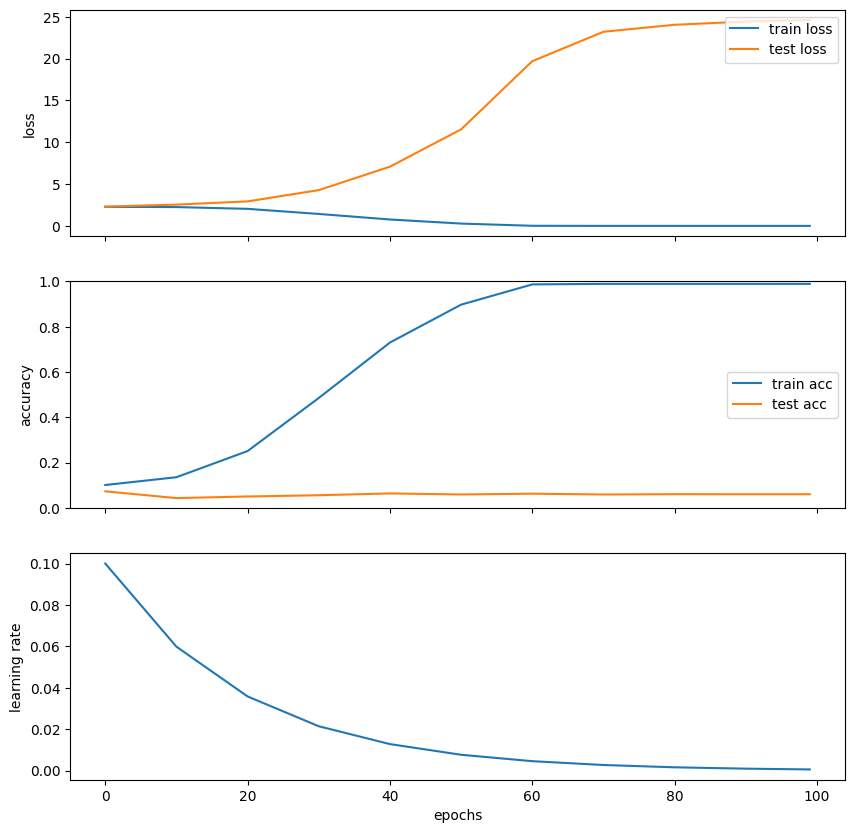

In [ ]:
# plot training statistics
fig, axs = plt.subplots(3, figsize=(10,10), sharex=True)
epochs = np.arange(len(metrics['test']['loss'])) * 10
if last_epoch % 10 != 0:
    epochs[-1] = last_epoch

axs[0].plot(epochs, metrics['train']['loss'], label='train loss')
axs[0].plot(epochs, metrics['test']['loss'], label='test loss')
axs[0].legend(loc='upper right')
axs[0].set_ylabel('loss')
axs[1].plot(epochs, metrics['train']['accuracy'], label='train acc')
axs[1].plot(epochs, metrics['test']['accuracy'], label='test acc')
axs[1].legend(loc='center right')
axs[1].set_ylabel('accuracy')
axs[1].set_ylim(0., 1.0)

# plot learning rate schedule
num_batches = len(train_loader)
lr_scheduler = get_lr_scheduler(
    lr, lr_step, lr_decay, steps_per_epoch=num_batches)
lr_schedule = [jax.device_get(lr_scheduler(epoch * num_batches)).item() for epoch in epochs]

axs[2].plot(epochs, lr_schedule)
axs[2].set_ylabel('learning rate')
axs[2].set_xlabel('epochs')

## Explicit regularization

If unregularized networks can fit arbitrary labellings of the data, what factors control the learning of patterns that generalize to unseen data? Is the success of deep learning simply explained by the right choice of explicit regularization?

The following plot shows the effectiveness of several regularization techniques at contrasting memorization, by comparing the training accuracy reached under several degrees of label noise. Furthermore, for each combination of regularization techniques, the best validation accuracy on clean labels is reported in the legend of the plot.

![Comparison of several explict regularization techniques](figs/expl_regularization.png "Explicit regularization vs label noise")

### Questions

* Which technique is most effective at hindering memorization?
* Which technique yields the best performance when no corrupted training labels are present?
* Is learning only possible with explicit regularization? Motivate!

### Answers
- The data augmentation with weight decay hindering memorization the most.
- The data augmentation with weight decay also performs the best when no corrupted training labels are present.
- Implicit regularization is also effectively hindering memorization sometimes.

## Implicit regularization

In this last plot, several regularization techniques are compared on clean labels, against learning without explicit regularization. All networks have been trained until a target training cross-entropy loss value of $0.19$ was reached.

![Explicit vs implict regularization](figs/impl_regularization.png "Explicit vs implicit regularization")

* What do you observe? Is explicit regulaziation needed for achieving non-trivial performance?
* If explict regularization alone does not explain learning, could you speculate on what factors, implicit in standard deep learning, are responsible for generalization?

###Answers
- Model without any explicit regularization can also achieve a good results.
- EarlyStopping implicitly leads to the generalization of a deep model.

## Next steps
The code provided in this notebook is slightly more general than what is required to solve the assignment. In fact, you can use the code to train your networks on clean labels, for instance by also enabling data augmentation and batch normalization. If you choose to do so, you probably need to tweak the learning rate schedule as well. Below, one example of a piece-wise constant learning rate policy, often used in practice, is provided.

You can use the schedule proposed to train a VGG-11 network, on clean labels (`label_noise = 0.`), with data augmentation. For such network, it is suggested to use a small weight decay, like $1\rm{e}-4$ and start with a smaller initial learning rate `lr = 0.01`. Such network will be needed for completing the optional task of Part II.

In [ ]:
num_batches = len(train_loader)
step_lr_schedule_args = {30 * num_batches: 0.5, 60 * num_batches: 0.5, 90 * num_batches: 0.5}
scheduler = optax.piecewise_constant_schedule(init_value=lr, boundaries_and_scales=step_lr_schedule_args)

Finally, it is valuable for us to know how long did it take you to complete this practical.

- It took 2 hours for me to finish this practical assignment.

## Acknowledgements

* The data loading boilerplate code and the training algorithm are adapted from the [official JAX documentation](https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html).

* ResNet definition adapted from the official [FLAX ImageNet example](https://github.com/google/flax/blob/master/examples/imagenet/models.py).

* PIL to numpy array transforms are adapted from the following [CIFAR-10 example](https://github.com/hushon/JAX-ResNet-CIFAR10/blob/main/train.py).


## References
1. [Understanding deep learning requires rethinking generalization](https://arxiv.org/abs/1611.03530)  - Zhang et al. ICLR 2017.
2. [A Closer Look at Memorization in Deep Networks](https://icml.cc/Conferences/2017/ScheduleMultitrack?event=1327) - Arpit et al. ICML 2017.
3. [Sensitivity and Generalization in Neural Networks: an Empirical Study](https://openreview.net/forum?id=HJC2SzZCW) - Novak et al. ICLR 2018.
4. [In Search of the Real Inductive Bias: On the Role of Implicit Regularization in Deep Learning](https://openreview.net/forum?id=6AzZb_7Qo0e) - Neyshabur, Tomioka, and Srebro. ICLR Workshop Track 2015.

## Changelog
| Version 	| Contribution      	| Author (Affiliation) 	                | Contact 	        |
|---------	|-------------------	|-----------------------------------    |---------	        |
| 1.0     	| First development 	| Matteo Gamba (KTH/EECS/RPL)       	|  ![contact address](figs/contact.png "Contact information") 	|